# Environment

## Libraries

In [1]:
import os, subprocess, json, requests, getpass, urllib.parse, sys, pathlib, warnings, numpy as np, \
pandas_profiling, seaborn as sns, pandas as pd, matplotlib.pyplot as plt, google.cloud.bigquery as bigquery

from bs4 import BeautifulSoup
from astropy.visualization import hist as astro_hist
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

## Specifying the Working Directory

In [2]:
workingdir = os.environ["DIR_PROJ"]

## Dealing with Warnings

In [3]:
pd.set_option("mode.chained_assignment", None)

## Function Definitions

In [4]:
def create_wordcloud(df: pd.DataFrame, what: str):
    posts = df[['body']].apply(lambda x:  ''.join(x), axis=0)[0]   
    soup = BeautifulSoup(posts, "html.parser")
    obj_array = soup.find_all(what)
    text = ""

    for obj in obj_array:
        text += obj.text

    stopwords = set(STOPWORDS)
    wordcloud_obj = WordCloud(stopwords=stopwords).generate(text)

    return wordcloud_obj

In [5]:
def code_block_number(string: str) -> int:
    if string == None:
        return 0
    
    soup = BeautifulSoup(string, 'html.parser')
    obj_array = soup.find_all('code')

    return len(obj_array)

In [6]:
def check_existence(element: str, input_list: list) -> list:
    output = []
    for val in input_list:
        if element in val:
            output.append(True)
        else:
            output.append(False) 
    return output

## Specifying GCP-Related Variables 

In [7]:
try:
    tmp = os.environ["PROJECT_ID"]
except:
    print("Env variable PROJECT not defined!")

try:
    tmp = os.environ["BUCKET_NAME"]
except:
    print("Env variable BUCKET_NAME not defined!")

# Exploratory Data Analysis

In [8]:
client = bigquery.Client()

## Tags

<a href='https://stackoverflow.com/help/tagging' target='_blank'>What are tags, and how should I use them?</a>

In [9]:
query = """SELECT
 *
FROM
  stackoverflow.tags
WHERE
  tag <> ''
ORDER BY
  count desc"""
df_tags = client.query(query).to_dataframe()

### How are the Tags Distributed?

In [10]:
features = ["count"]

In [11]:
df_tags[features].describe().loc[['count','25%', '50%', '75%']]

count
count  45426.0
25%        9.0
50%       34.0
75%      142.0

In [12]:
total_tags = df_tags['count'].sum()
total_tags

35100756

In [13]:
df_tags['count_rel'] = (df_tags['count'] / total_tags) * 100

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


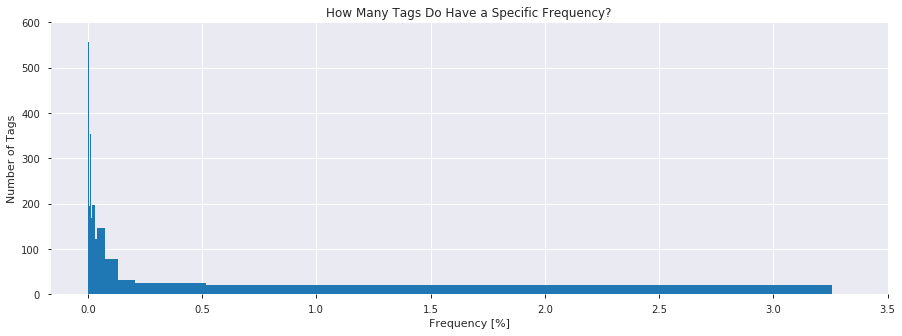

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

astro_hist(df_tags['count_rel'], bins='blocks', histtype='stepfilled')

ax.set(ylim=[0, 600], xlabel='Frequency [%]', ylabel="Number of Tags", 
       title='How Many Tags Do Have a Specific Frequency?',
       xticks=np.arange(0,3.6, 0.5));

### Which Tags Are Most Frequent?

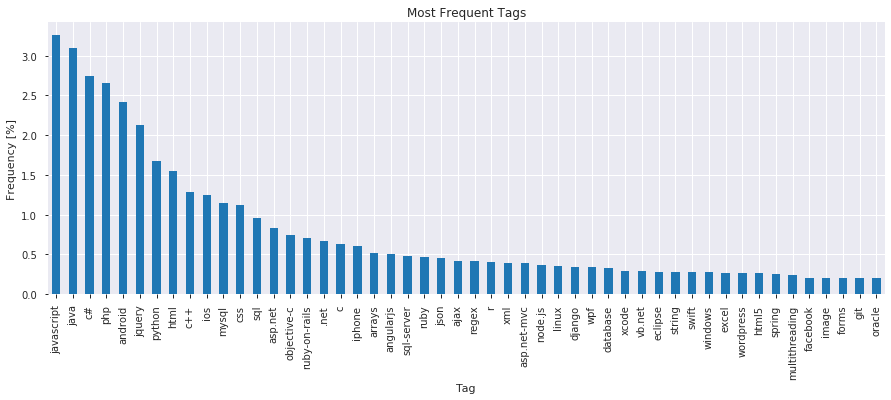

In [15]:
ax = df_tags.iloc[0:50].plot(x='tag', y='count_rel', kind='bar', figsize=(15, 5), title='Most Frequent Tags')
ax.set(ylabel='Frequency [%]', xlabel='Tag')
ax.get_legend().remove()

### Cumulative Frequency of the Most Frequent Tags

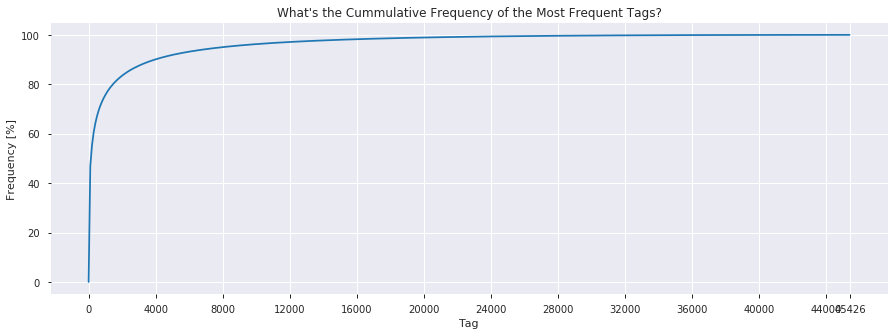

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
y_values = []
x_values = []

for category in range(0, len(df_tags), 100):
    value = df_tags["count"].iloc[0:category].sum()
    y_values.append((value / total_tags) * 100)
    x_values.append(category)

ax.plot(x_values, y_values, color='#1f77b4')
ax.set(xlabel='Tag', ylabel='Frequency [%]', title="What's the Cummulative Frequency of the Most Frequent Tags?")
ax.set_xticks(list(range(0, len(df_tags), 4000)) + [len(df_tags)]);

### Cumulative Frequency of Posts (If a Subset of Labels Is Allowed Only)

In [17]:
query = """SELECT
  (COUNT(DISTINCT(id)) / (
  SELECT
    COUNT(DISTINCT(id))
  FROM
    `nlp-text-classification.stackoverflow.posts_p1_subset`))*100
FROM
  `nlp-text-classification.stackoverflow.posts_p1_subset`,
  UNNEST(tags) AS tag_unit
WHERE
  tag_unit IN (
  SELECT
    tag
  FROM
    `nlp-text-classification.stackoverflow.tags`
  WHERE tag <> ''
  ORDER BY
    count DESC
  LIMIT
    {limit}) AND tag_unit <> '' """

In [18]:
occurrences = []
for tag_no in range(1, 1001, 20):
    df_occurrences = client.query(query.format(limit=tag_no)).to_dataframe()
    occurrence = df_occurrences.values[0][0]
    occurrences.append(occurrence)

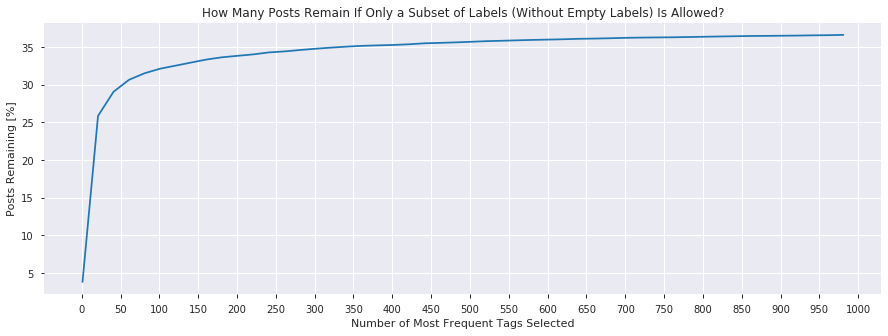

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

ax.plot(range(1, 1001, 20), occurrences, color='#1f77b4')
ax.set(xlabel='Number of Most Frequent Tags Selected', ylabel='Posts Remaining [%]', 
       title='How Many Posts Remain If Only a Subset of Labels (Without Empty Labels) Is Allowed?')
ax.set_xticks(range(0, 1001, 50));

## Posts

In [20]:
query = """SELECT
  *
FROM
  stackoverflow.posts_p1_subset"""
df_posts = client.query(query).to_dataframe()

In [21]:
features = [
    'title',
    'body',
    'answer_count',
    'comment_count',
    'favorite_count',
    'score',
    'tags',
    'view_count',
]
report_features = [
    'answer_count',
    'comment_count',
    'favorite_count',
    'score',
    'tags',
    'view_count',
]

In [22]:
df_posts[features].head()

title                                               body  answer_count  \
0  None  <p>You can simply nest it like this:</p> <pre>...           NaN   
1  None  <p>As you are using this VHOST on port 8080. Y...           NaN   
2  None  <p>Here is my environment and I can run scrapy...           NaN   
3  None  <p><a href= http://msdn.microsoft.com/en-us/li...           NaN   
4  None                                               None           NaN   

   comment_count  favorite_count  score tags  view_count  
0              0             NaN      0   []         NaN  
1              1             NaN      0   []         NaN  
2              2             NaN      0   []         NaN  
3              0             NaN      0   []         NaN  
4              0             NaN      0   []         NaN

### Report

In [23]:
posts_report = df_posts[report_features].profile_report()

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


In [24]:
posts_report

### Code: Wordcloud

In [25]:
df_posts_subset = df_posts[df_posts['tags'] != '']

In [26]:
langs = df_tags['tag'].iloc[0:10]

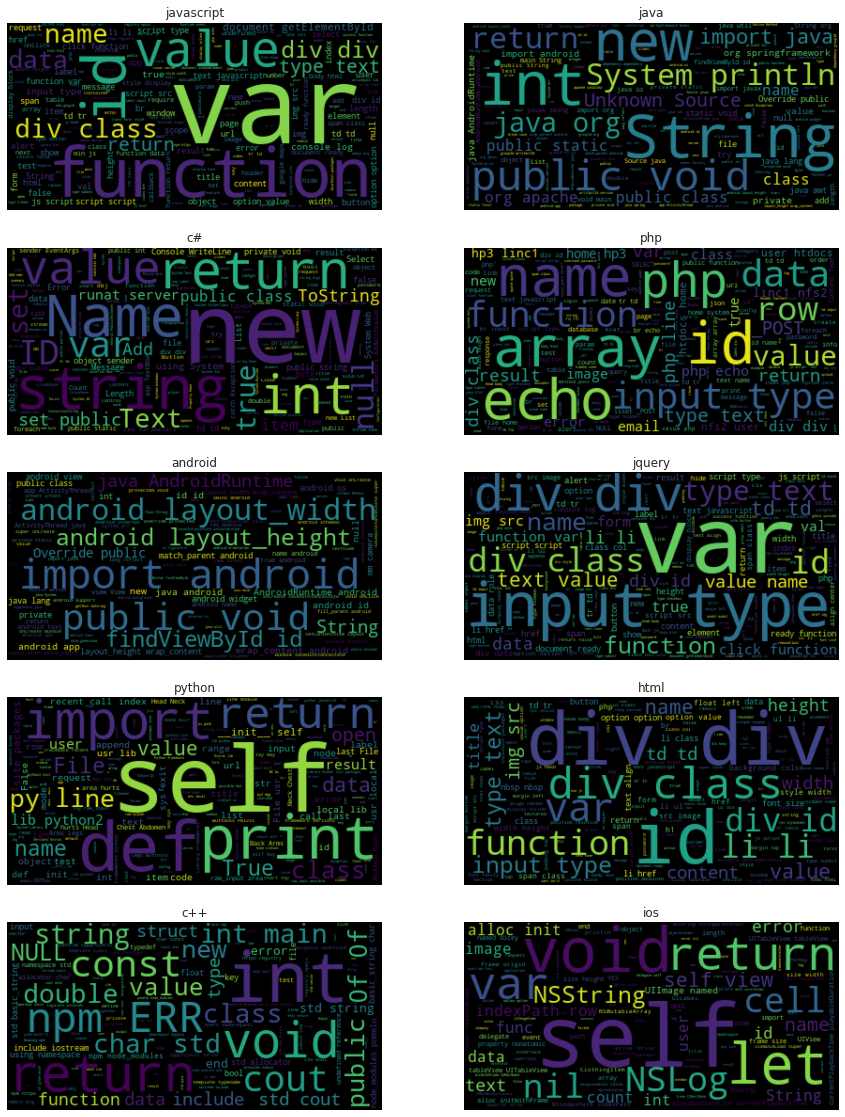

In [27]:
fig = plt.figure(figsize=(15, 20))

for lang, num in zip(langs, range(0, len(langs))):
    temp = df_posts_subset[check_existence(lang, df_posts_subset['tags'])]
    worcloud_temp = create_wordcloud(temp, 'code')

    ax = fig.add_subplot(5, 2, num + 1)

    ax.imshow(worcloud_temp, interpolation='bilinear')
    ax.set(title=lang)
    ax.axis('off')

### Post: Wordcloud

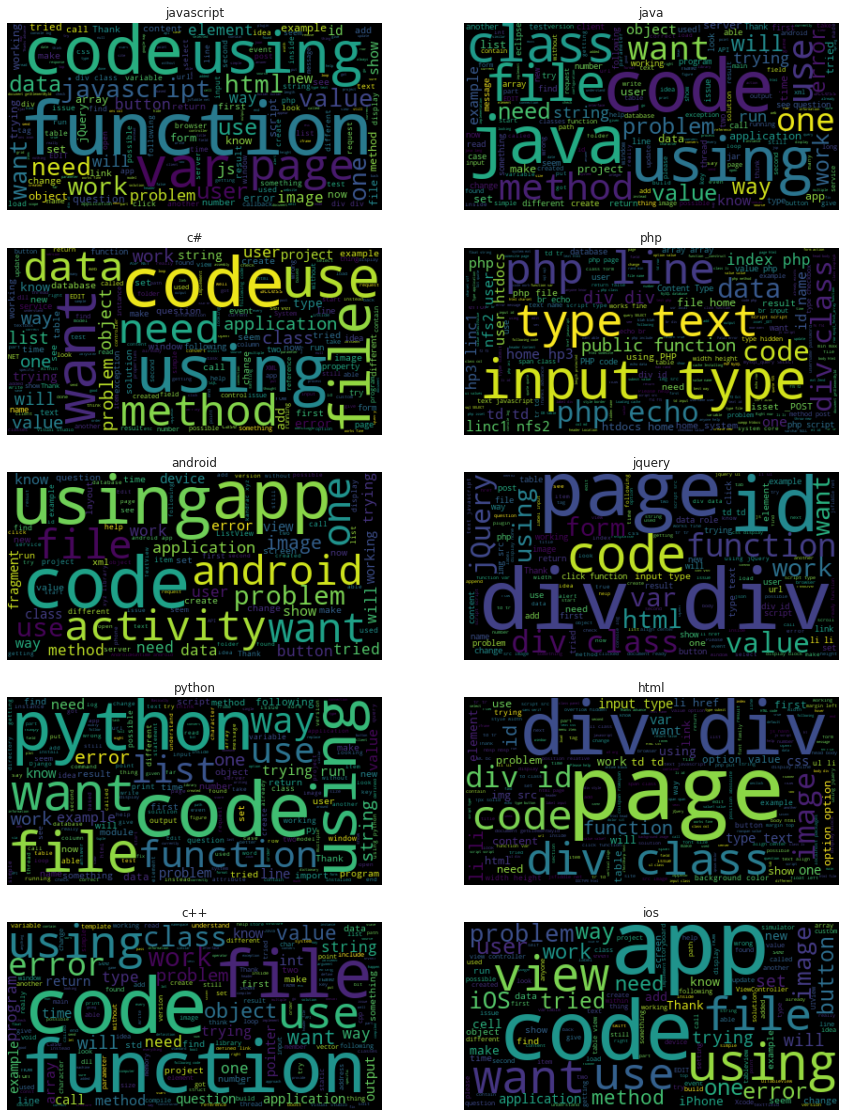

In [28]:
fig = plt.figure(figsize=(15, 20))

for lang, num in zip(langs, range(0, len(langs))):
    temp = df_posts_subset[check_existence(lang, df_posts_subset['tags'])]
    worcloud_temp = create_wordcloud(temp, 'p')

    ax = fig.add_subplot(5, 2, num + 1)

    ax.imshow(worcloud_temp, interpolation='bilinear')
    ax.set(title=lang)
    ax.axis("off")

### How Many Posts Do Have a Codeblock?

In [29]:
df_posts_subset.head()

id title                                               body  \
0  28972459  None  <p>You can simply nest it like this:</p> <pre>...   
1  24990792  None  <p>As you are using this VHOST on port 8080. Y...   
2  18669193  None  <p>Here is my environment and I can run scrapy...   
3  10848627  None  <p><a href= http://msdn.microsoft.com/en-us/li...   
4  14852778  None                                               None   

   accepted_answer_id  answer_count  comment_count community_owned_date  \
0                 NaN           NaN              0                  NaT   
1                 NaN           NaN              1                  NaT   
2                 NaN           NaN              2                  NaT   
3                 NaN           NaN              0                  NaT   
4                 NaN           NaN              0                  NaT   

                     creation_date  favorite_count  \
0 2015-03-10 19:29:14.437000+00:00             NaN   
1 2014-07-28 07:58:01.983000+00:00             NaN   
2 2013-09-07 02:51:21.827000+00:00             NaN   
3 2012-06-01 10:27:52.780000+00:00             NaN   
4 2013-02-13 11:44:01.820000+00:00             NaN   

                last_activity_date                   last_edit_date  \
0 2015-03-10 19:29:14.437000+00:00                              NaT   
1 2014-07-28 07:58:01.983000+00:00                              NaT   
2 2013-09-07 02:51:21.827000+00:00                              NaT   
3 2012-06-01 10:27:52.780000+00:00                              NaT   
4 2013-02-13 11:44:01.820000+00:00 2013-02-13 11:44:01.820000+00:00   

  last_editor_display_name  last_editor_user_id owner_display_name  \
0                     None                  NaN               None   
1                     None                  NaN               None   
2                     None                  NaN               None   
3                     None                  NaN               None   
4                     None                 -1.0               None   

   owner_user_id   parent_id  post_type_id  score  view_count tags  
0      4198813.0  28972371.0             2      0         NaN   []  
1      3872235.0  24983730.0             2      0         NaN   []  
2      1115857.0  18668696.0             2      0         NaN   []  
3       147211.0  10845460.0             2      0         NaN   []  
4           -1.0         NaN             5      0         NaN   []

In [30]:
df_posts_subset['codeblocks'] = df_posts_subset['body'].apply(
    lambda string: code_block_number(string)
)

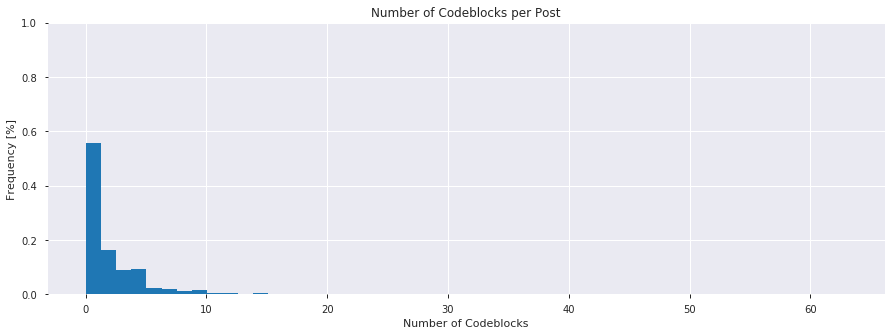

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

df_posts_subset['codeblocks'].plot(
    kind="hist",
    bins=50,
    weights=np.zeros_like(df_posts_subset['codeblocks'])
    + 1.0 / df_posts_subset['codeblocks'].size,
)

ax.set(title='Number of Codeblocks per Post', xlabel='Number of Codeblocks', ylabel='Frequency [%]', ylim=[0,1]);

### How Much Tags Are There Per Post?

In [32]:
df_posts_subset['tag_count'] = df_posts_subset['tags'].apply(len)

In [33]:
df_posts_subset['tag_count'].describe()

count    31018.000000
mean         1.747211
std          1.210864
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          5.000000
Name: tag_count, dtype: float64

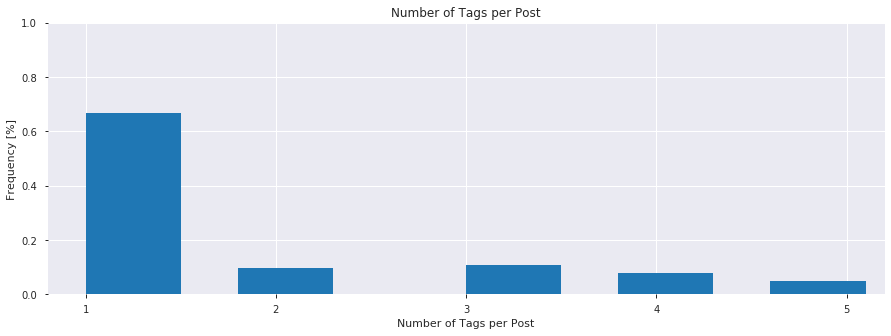

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

ax.hist(df_posts_subset['tag_count'], width=0.5, \
        weights=np.zeros_like(df_posts_subset['tag_count']) + 1. / df_posts_subset['tag_count'].size)

ax.set(xlabel='Number of Tags per Post', xticks=range(1, 6), ylabel='Frequency [%]', title='Number of Tags per Post',
      ylim=[0,1]);